In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
from matplotlib import dates
import datetime

import sys
sys.path.append('../src')
from visualization import CandlestickChart

from window import WindowGenerator
from MLUtilities import Baseline, ResidualWrapper, compile_and_fit


import seaborn as sbn
import tensorflow as tf
import IPython
import IPython.display

# Data
- The daily OHLC forexdata is pulled from the Alpha Vantage API [RapidAPI](https://rapidapi.com/alphavantage/api/alpha-vantage). This public REST API is useful for receiving stock, ETF, forex, technical indicators, and cryptocurrency data.

- In this notebook we look at INR/SEK pair but everything below is useful for any time series data.

## Exploratory data analysis

In [2]:
# Upload the data from the csv file

df = pd.read_csv('forexdata.csv')
df.columns = ["Dates","open","high","low","close"]

# Feature engineering: string datetime to datetime object
df.index = pd.to_datetime(df.pop('Dates'), format='%Y-%m-%d')

# See how the data looks
df.head()

,open,high,low,close
Dates,,,,
2014-11-24,8.2673,8.3276,8.2571,8.3089
2014-11-25,8.3068,8.3393,8.2841,8.3284
2014-11-26,8.3265,8.3641,8.3099,8.3495
2014-11-27,8.3486,8.3674,8.2846,8.3147
2014-11-28,8.3143,8.3762,8.2800,8.3598


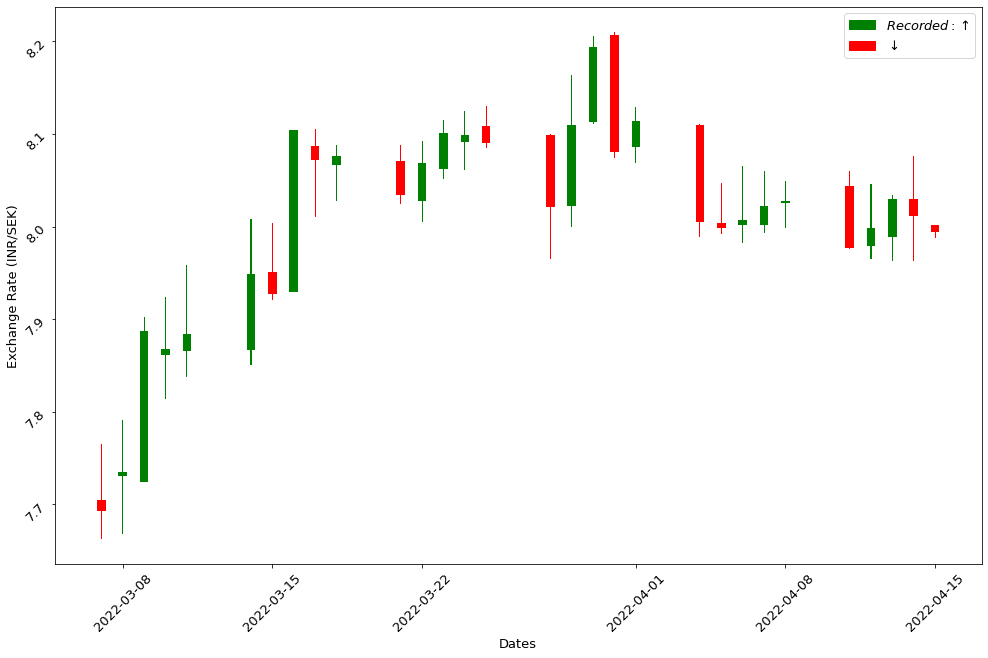

In [3]:
# Plot candlestick chart for the last 30 days

plot = CandlestickChart(record=df.tail(30),savefig=False)
plot.chart()

In [4]:
#Basic Stats

df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
open,1928.0,7.883428,0.443575,7.0746,7.504050,7.82850,8.156875,8.9783
high,1928.0,7.919274,0.442766,7.0889,7.540025,7.86555,8.189750,8.9910
low,1928.0,7.848221,0.442385,7.0319,7.472600,7.79310,8.115900,8.9182
close,1928.0,7.883494,0.443316,7.0681,7.507250,7.82875,8.156900,8.9684


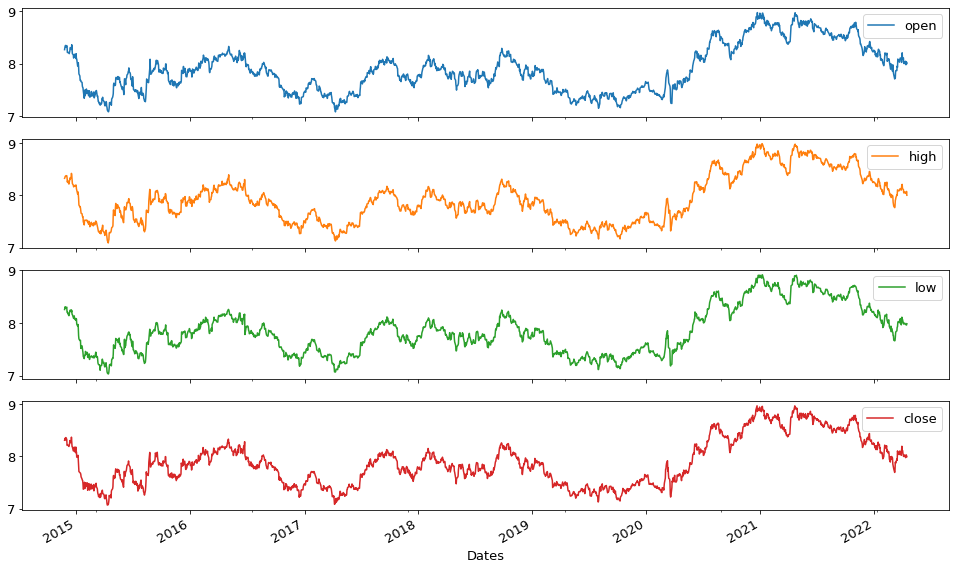

In [5]:
# Visualizing the input OHLC signal

plot_cols = ['open', 'high', 'low', 'close']
_ = df[plot_cols].plot(subplots=True)

# Forecasting 

  - We use [TensorFlow 2.0](https://www.tensorflow.org/api_docs/python/tf)

  - We want to forcast the OHLC values of the FOREX using machine learning (ML) model like the `RNN-LSTM` (Recurrent Neural Network- Long-Short Term Memory)

  - We do not perform `data resampling` as we already have daily values.

  ## Training, Validation and Testing

   - We use all the daily OHLC data available from 2014 and divide the sequential data into `(70,20,10)%` for the *training, validation* and *test* set.

  ## Data Windowing

   - `batch size` = 32, basically partitions the training, val and test sets into batches
   - `window width` is a collection of consecutive input data and lables
   - `lable` or `target` is what the neural net should predict
   - `prediction` is what neural net predicts

  ## TensorBoard

   - For measuring and visualizing the progress of the model training, [TensorBoard](https://www.tensorflow.org/tensorboard/get_started)
       - Use `--port default` to use the default [6006] port. Otherwise it tries to use a stale process
       - Read [here](https://github.com/tensorflow/tensorboard/blob/master/README.md) to understand what individual plots in the TensorBorad mean.

In [6]:
# Load the TensorBoard notebook extension
# Use `reload_ext' to reload

%load_ext tensorboard

In [7]:
%%bash
mkdir -p logs/fit
# Use this cell as typical terminal
# create the required dir for the logs

In [8]:
#Split the data into train, validation and test (70%,20%,10%)

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

In [9]:
# Normalization of the input signal

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

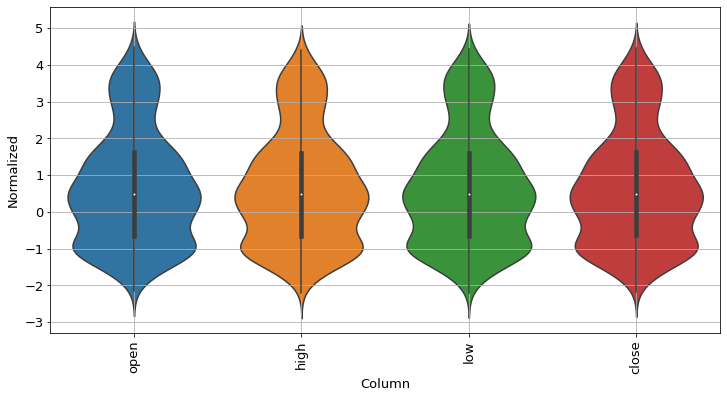

In [10]:
# Visualizing the data using a violinplot

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sbn.violinplot(x='Column', y='Normalized', data=df_std)
plt.grid()
_ = ax.set_xticklabels(df.keys(), rotation=90)

#### Note on `violinplot`:

- The 'white dot' is the median, the thick bar extensions are the Q1 and Q3 interquartile ranges (Q2 being the median) and the thin bars are some scale of the Q1 and Q3 (here 1.5 x Q1 or Q3) The spread of the colormap represents the probability distribution.

# Utilities and Models

Input: (32, 30, 4)
Lables: (32, 30, 4)


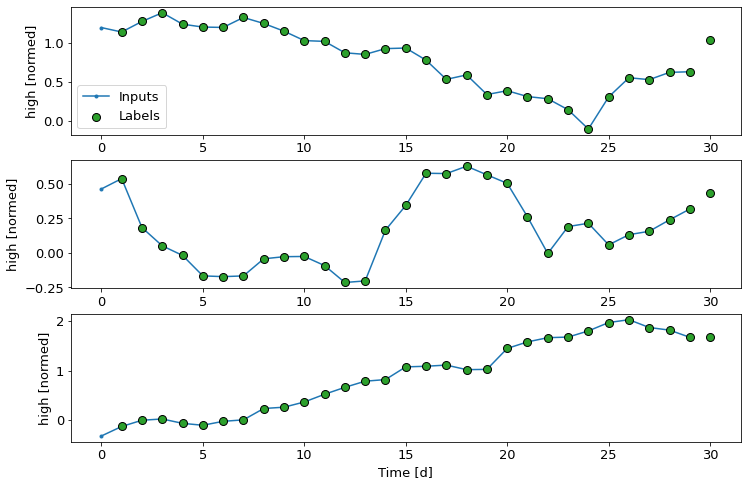

In [11]:
# Multi (feature) output models using multiple-time-step input

""" The window object creates tf.data.Datasets from the training,
    validation, and test sets allowing one to easily iterate over
    batches of data. """

# For the Baseline model 30-days data to make 30 predictions
wide_window = WindowGenerator(train_df=train_df,val_df=val_df,test_df=test_df,
    input_width=30, label_width=30, shift=1)

# Print out some useful diagnostics about the window and plot
# using the plot method from WindowGenerator class
wide_window.plot(plot_col='high')
print(f'Input: {wide_window.example[0].shape}')
print(f'Lables: {wide_window.example[1].shape}')

## Baseline model

- Needs input width = lable width so that output == lable width
- NOT a multi-step input -- single step prediction
- Is a single step input-- single step output model

In [12]:
#Calling the Baseline model for single step output for the batch

baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [13]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

val_performance = {}
performance = {}

history = compile_and_fit(baseline, wide_window,
                          tbCallback=tensorboard_callback, MAX_EPOCHS=100)

IPython.display.clear_output()
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

12/12 [==============================] - 0s 4ms/step - loss: 0.0279 - mean_absolute_error: 0.1255


In [14]:
%tensorboard --port default --purge_orphaned_data False --logdir logs/fit

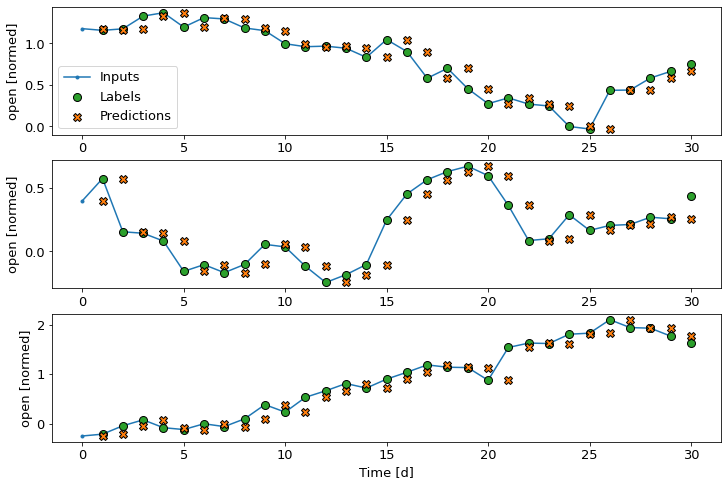

In [15]:
# Plot the result from the Baseline model

wide_window.plot(baseline)

## Recurrent Neural Networks
- Long-Short Term Memory (LSTM) ('tanh' acitvation used by default, 'sigmoid' for recurrent_activation)
    - With return_sequences=True, it returns prediction for each input
    - With return_sequences=False, it returns a prediction only for the shift
    - [Doc](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)
    
- Residual LSTM

## LSTM Layer

In [16]:
%%time

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Redefining the window 
# Now multi-time-step input and a single prediction
# Set 'return_sequences=True' to get predicitons for
# all labels and change label_width accordingly.

wide_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=30, label_width=30, shift=1)

# Define a LSTM layer with 32 units and
# an output layer with 'num_features' unit.

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window,
                          tbCallback=tensorboard_callback, MAX_EPOCHS=200)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

12/12 [==============================] - 0s 7ms/step - loss: 0.3662 - mean_absolute_error: 0.4359
CPU times: total: 1min 12s
Wall time: 40.5 s


In [17]:
%tensorboard --port default --purge_orphaned_data False --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10332), started 0:01:11 ago. (Use '!kill 10332' to kill it.)

Input: (32, 30, 4)
Lables: (32, 30, 4)
Output: (32, 30, 4)


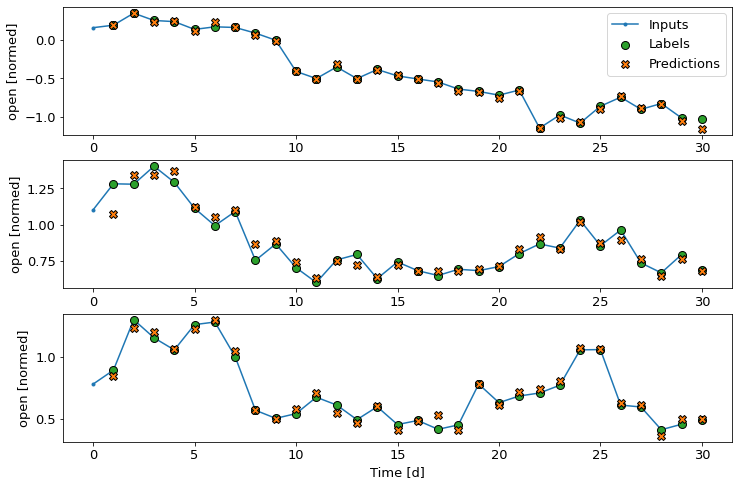

In [18]:
# Print out some useful diagnostics for the redefined window and plot
# model results.

print(f'Input: {wide_window.example[0].shape}')
print(f'Lables: {wide_window.example[1].shape}')
print(f'Output: {lstm_model(wide_window.example[0]).shape}')

 # In the plot the output is reshaped to match the labels shape
wide_window.plot(lstm_model,'open')

#### Notes on LSTM:

- 'return_sequences=False' seems to perform really bad.
- 'return_sequences=True' seems good (is it overfitting?!) 
    - check the plot for the loss curve (TensorBoard plots)

## Residual LSTM Layer

In [19]:
%%time

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Redefining the window 
# Now multi-time-step input and multi-step prediction
# Set 'return_sequences=True' to get predicitons for
# all labels and change label_width accordingly.

wide_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
    input_width=30, label_width=30, shift=1)

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window,
                          tbCallback=tensorboard_callback, MAX_EPOCHS=200)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

12/12 [==============================] - 0s 8ms/step - loss: 0.0200 - mean_absolute_error: 0.1024
CPU times: total: 38.4 s
Wall time: 22.8 s


In [20]:
%tensorboard --port default --purge_orphaned_data False --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10332), started 0:02:10 ago. (Use '!kill 10332' to kill it.)

Input: (32, 30, 4)
Lables: (32, 30, 4)
Output: (32, 30, 4)


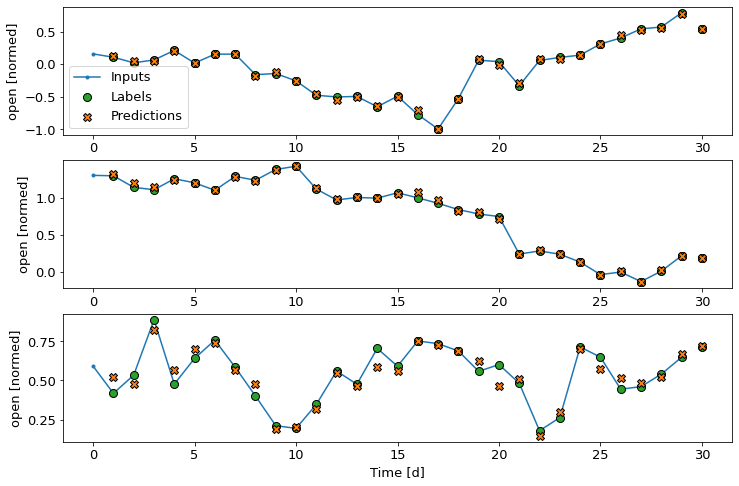

In [21]:
# Print out some useful diagnostics for the redefined window and plot
# model results.

print(f'Input: {wide_window.example[0].shape}')
print(f'Lables: {wide_window.example[1].shape}')
print(f'Output: {residual_lstm(wide_window.example[0]).shape}')

wide_window.plot(residual_lstm)

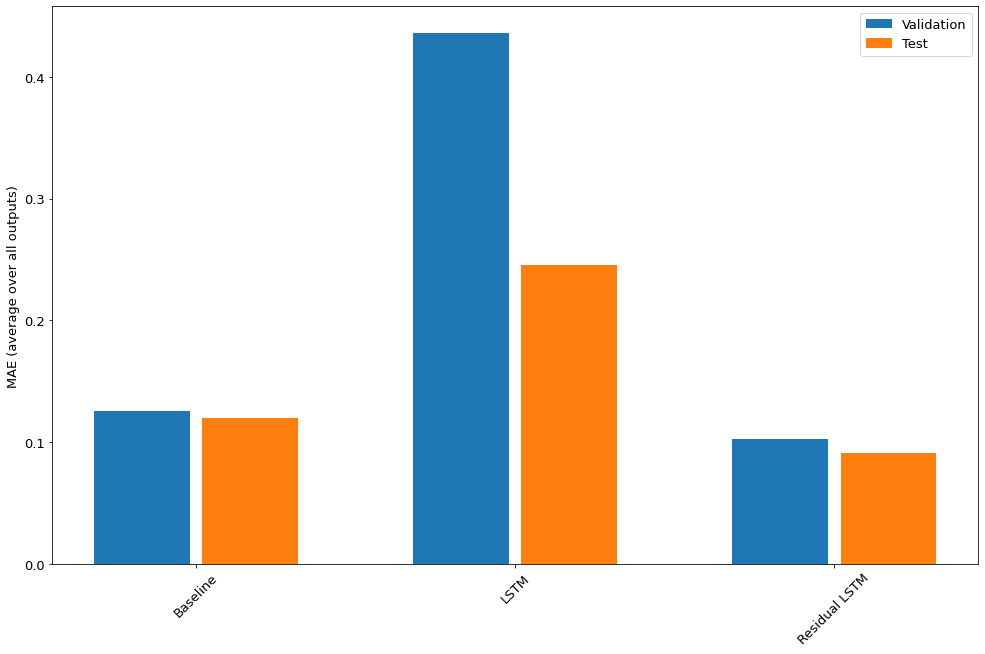

In [22]:
#Performance visualization for all the three models

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]


plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [23]:
# Print out the preformance metric for all the models so far

for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

Baseline       : 0.1196
LSTM           : 0.2452
Residual LSTM  : 0.0910


# Before saving ML model

- Train the entire dataset i.e, without dividing the data into train, validation and test sets.
- `Remember` to Normalize the entire data before training.
- Normalize with the all-df mean? Issues?

In [24]:
# Normalize entire dataset

df_all = (df - df.mean()) / df.std()

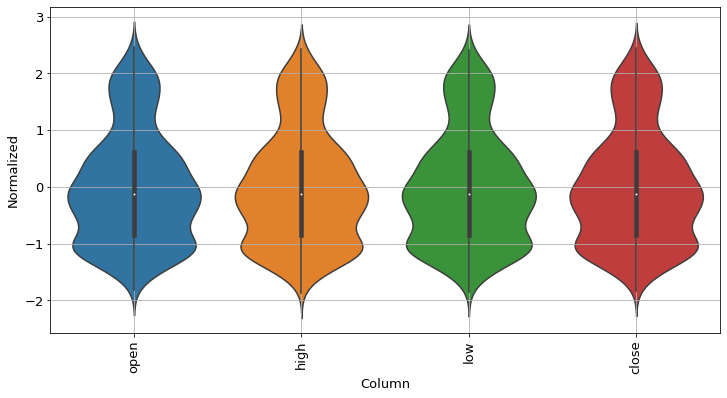

In [25]:
# Check againg the distribution of the entire normalized data

df_std = df_all.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sbn.violinplot(x='Column', y='Normalized', data=df_std)
plt.grid()
_ = ax.set_xticklabels(df_all.keys(), rotation=90)

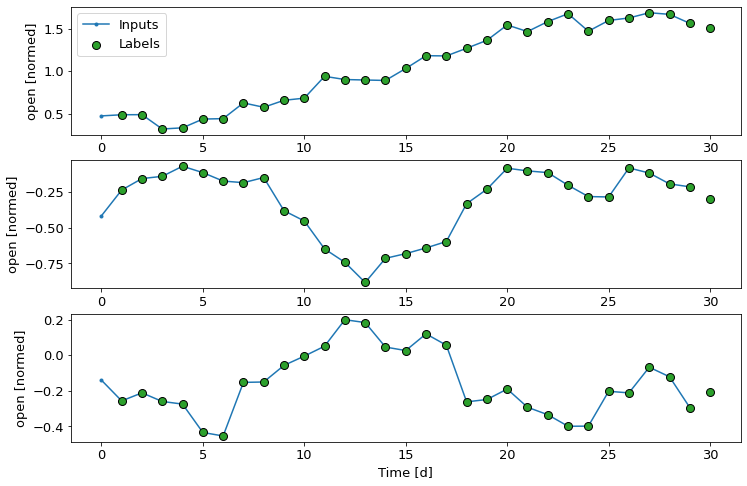

In [26]:
# window for multi-step input for multi-step prediction
# Note no more validation and test set!

full_data_window = WindowGenerator(train_df=df_all,val_df=None,test_df=None,
    input_width=30, label_width=30, shift=1)

full_data_window.plot()

In [27]:
%%time

# Train the entire dataset with the Residual LSTM Model

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=2,
                                                    mode='min')

residual_lstm.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

history = residual_lstm.fit(full_data_window.train, epochs=200,
                      callbacks=[early_stopping,tensorboard_callback])
                      


IPython.display.clear_output()

CPU times: total: 1min 8s
Wall time: 37.4 s


In [28]:
%tensorboard --port default --purge_orphaned_data False --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 10332), started 0:03:43 ago. (Use '!kill 10332' to kill it.)

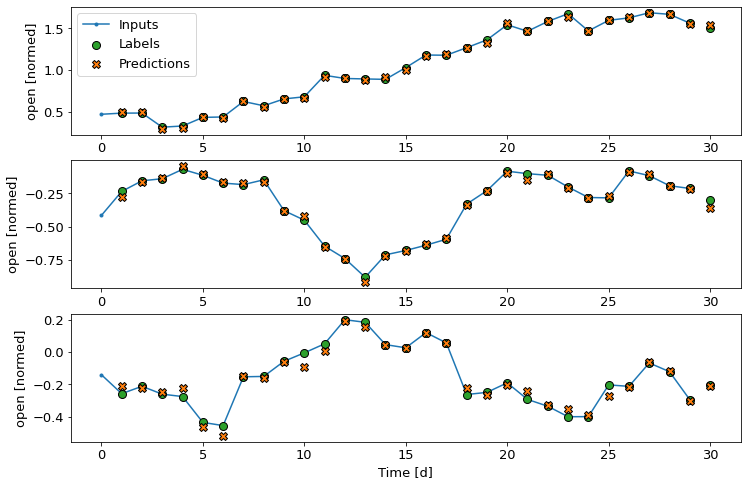

In [29]:
full_data_window.plot(residual_lstm,plot_col='open')

# Save the model
- There are warnings (as below) while saving. Custom models (like the current) can be saved using the SaveModel method [TensorFlowDoc](https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model)
- After reloding the saved model, check consistency to be sure the predictions you make using the saved model are as expected
- All the data preprocessing applied before training should also be applied to the data used for making predictions.

In [30]:
# packages needed for saving the model

import h5py as h5
from tensorflow import keras

In [31]:
# save model to single file

residual_lstm.save('../saved_model/residual_lstm_model')

INFO:tensorflow:Assets written to: ../saved_model/residual_lstm_model\assets


INFO:tensorflow:Assets written to: ../saved_model/residual_lstm_model\assets


---